In [1]:
%matplotlib widget

import numpy as np
import k3d
from ipywidgets import widgets, interact, HBox, VBox
from ipycanvas import Canvas
import pyzed.sl as sl
from PIL import Image
from tqdm import tqdm
import os

In [2]:
# Configuration
# SVO_FILE = "../../data/HD720_SN15604367_14-35-18.svo2"
SVO_FILE = "../../data/HD720_SN38781663_10-23-10.svo2"

MAX_SECONDS = 10  # Only read first N seconds
SET_FLOOR_AS_ORIGIN = False

# === Body Tracking Settings ===
# Option 1: BODY_18 with fitting (uncomment to use)
# BODY_FORMAT = sl.BODY_FORMAT.BODY_18
# ENABLE_BODY_FITTING = True
# SKELETON_SMOOTHING = 0.0  # 0.0 = no smoothing, 1.0 = max smoothing

# Option 2: BODY_34 with smoothing (uncomment to use)
BODY_FORMAT = sl.BODY_FORMAT.BODY_34
ENABLE_BODY_FITTING = True  # Always True for BODY_34
SKELETON_SMOOTHING = 1.0  # Try: 0.0, 0.2, 0.5, 0.7, 1.0

In [3]:
# Initialize ZED
zed = sl.Camera()

init_params = sl.InitParameters()
init_params.set_from_svo_file(SVO_FILE)
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_mode = sl.DEPTH_MODE.NEURAL_PLUS
init_params.coordinate_system = sl.COORDINATE_SYSTEM.RIGHT_HANDED_Z_UP

err = zed.open(init_params)
if err != sl.ERROR_CODE.SUCCESS:
    raise RuntimeError(f"Failed to open SVO file: {err}")

camera_info = zed.get_camera_information()
fps = camera_info.camera_configuration.fps
total_frames = zed.get_svo_number_of_frames()
max_frames = min(int(MAX_SECONDS * fps), total_frames)

print(f"FPS: {fps}")
print(f"Total frames: {total_frames}")
print(f"Reading first {max_frames} frames ({MAX_SECONDS} seconds)")

FPS: 60.0
Total frames: 4026
Reading first 600 frames (10 seconds)
[2026-01-25 06:59:38 UTC][ZED][INFO] Logging level INFO
[2026-01-25 06:59:39 UTC][ZED][INFO] [Init]  Depth mode: NEURAL PLUS
[2026-01-25 06:59:39 UTC][ZED][INFO] [Init]  Serial Number: S/N 38781663


In [4]:
# Enable positional tracking
positional_tracking_params = sl.PositionalTrackingParameters()
positional_tracking_params.set_as_static = True
if SET_FLOOR_AS_ORIGIN:
    positional_tracking_params.set_floor_as_origin = True
    print("Floor as origin: ENABLED")
else:
    print("Floor as origin: DISABLED")

zed.enable_positional_tracking(positional_tracking_params)

# Enable body tracking
body_param = sl.BodyTrackingParameters()
body_param.enable_tracking = True
body_param.detection_model = sl.BODY_TRACKING_MODEL.HUMAN_BODY_ACCURATE
body_param.body_format = BODY_FORMAT
body_param.enable_body_fitting = ENABLE_BODY_FITTING

zed.enable_body_tracking(body_param)

body_runtime_param = sl.BodyTrackingRuntimeParameters()
body_runtime_param.detection_confidence_threshold = 40
body_runtime_param.skeleton_smoothing = SKELETON_SMOOTHING

print(f"Body format: {BODY_FORMAT}")
print(f"Body fitting: {ENABLE_BODY_FITTING}")
print(f"Skeleton smoothing: {SKELETON_SMOOTHING}")

Floor as origin: DISABLED
Body format: BODY_FORMAT.BODY_34
Body fitting: True
Skeleton smoothing: 1.0


In [5]:
# Try to detect floor plane
floor_plane_eq = None
floor_mesh_vertices = None
floor_mesh_indices = None

# Need to grab a few frames first for floor detection
for _ in range(30):
    if zed.grab() != sl.ERROR_CODE.SUCCESS:
        break

plane = sl.Plane()
reset_transform = sl.Transform()
if zed.find_floor_plane(plane, reset_transform) == sl.ERROR_CODE.SUCCESS:
    floor_plane_eq = plane.get_plane_equation()
    print(f"Floor plane found: {floor_plane_eq}")
    print(f"  Normal: ({floor_plane_eq[0]:.3f}, {floor_plane_eq[1]:.3f}, {floor_plane_eq[2]:.3f})")
    print(f"  Distance: {floor_plane_eq[3]:.3f}")
    
    # Get floor mesh for visualization
    bounds = plane.get_bounds()
    if len(bounds) >= 4:
        floor_mesh_vertices = np.array(bounds, dtype=np.float32)
        # Create triangle indices for the quad
        floor_mesh_indices = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.uint32)
        print(f"  Floor bounds: {len(bounds)} vertices")
else:
    print("Floor plane NOT detected")

# Reset to beginning
zed.set_svo_position(0)

Floor plane found: [0.00538624 0.03826033 0.99925327 1.00831246]
  Normal: (0.005, 0.038, 0.999)
  Distance: 1.008
  Floor bounds: 62 vertices


In [6]:
# Collect body tracking data and extract frames
import cv2

os.makedirs("tmp", exist_ok=True)

frames_data = []  # List of dicts: {person_id: {'keypoints_3d': ..., 'keypoints_2d': ...}}
bodies = sl.Bodies()
image = sl.Mat()

# Track bounding box of all 3D keypoints
all_keypoints_3d = []

with tqdm(total=max_frames, desc="Reading frames") as pbar:
    frame_idx = 0
    while zed.grab() == sl.ERROR_CODE.SUCCESS and frame_idx < max_frames:
        # Retrieve bodies and image in same grab cycle
        zed.retrieve_bodies(bodies, body_runtime_param)
        
        # Try VIEW.LEFT - this should match keypoint_2d
        # ZED returns BGRA format
        zed.retrieve_image(image, sl.VIEW.LEFT, sl.MEM.CPU)
        
        # Save frame - cv2.imwrite handles BGRA correctly
        img_data = image.get_data()
        cv2.imwrite(f"tmp/{frame_idx:06d}.png", img_data)
        
        frame_bodies = {}
        for body in bodies.body_list:
            if body.tracking_state == sl.OBJECT_TRACKING_STATE.OK:
                kp3d = body.keypoint.copy()
                frame_bodies[int(body.id)] = {
                    'keypoints_3d': kp3d,
                    'keypoints_2d': body.keypoint_2d.copy(),
                    'bounding_box_2d': body.bounding_box_2d.copy(),
                }
                # Collect for bounding box calculation
                all_keypoints_3d.append(kp3d)
        
        frames_data.append(frame_bodies)
        frame_idx += 1
        pbar.update(1)

# Calculate 3D bounding box of all keypoints
if all_keypoints_3d:
    all_kps = np.vstack(all_keypoints_3d)
    keypoints_min = all_kps.min(axis=0)
    keypoints_max = all_kps.max(axis=0)
    keypoints_center = (keypoints_min + keypoints_max) / 2
    keypoints_extent = keypoints_max - keypoints_min
    print(f"\n3D Keypoints bounding box:")
    print(f"  Min: {keypoints_min}")
    print(f"  Max: {keypoints_max}")
    print(f"  Center: {keypoints_center}")
    print(f"  Extent: {keypoints_extent}")
else:
    keypoints_min = np.array([-2, -2, -2])
    keypoints_max = np.array([2, 2, 2])
    keypoints_center = np.array([0, 0, 0])

# Get image dimensions from first frame
sample_img = Image.open("tmp/000000.png")
img_width, img_height = sample_img.size

print(f"\nCollected {len(frames_data)} frames")
print(f"Frame size: {img_width}x{img_height}")
print(f"Persons detected: {set(pid for f in frames_data for pid in f.keys())}")

# Debug: Print calibration info
calib = zed.get_camera_information().camera_configuration.calibration_parameters
print(f"\nLeft camera resolution: {calib.left_cam.image_size.width}x{calib.left_cam.image_size.height}")
print(f"Left camera fx/fy: {calib.left_cam.fx:.1f}, {calib.left_cam.fy:.1f}")
print(f"Left camera cx/cy: {calib.left_cam.cx:.1f}, {calib.left_cam.cy:.1f}")

Reading frames: 100%|█████████████████████████████████████████████| 600/600 [00:42<00:00, 14.23it/s]


3D Keypoints bounding box:
  Min: [-1.5765502  0.4738942 -1.1034569]
  Max: [1.0381092  3.352498   0.68407136]
  Center: [-0.26922053  1.9131961  -0.20969275]
  Extent: [2.6146593 2.878604  1.7875283]

Collected 600 frames
Frame size: 1280x720
Persons detected: {0}

Left camera resolution: 1280x720
Left camera fx/fy: 528.3, 528.3
Left camera cx/cy: 652.6, 369.8


Floor transform created:
  Rotation matrix:
[[ 9.99985473e-01  2.71050543e-20 -5.39019079e-03]
 [-2.06230459e-04  9.99267806e-01 -3.82597706e-02]
 [ 5.38624413e-03  3.82603264e-02  9.99253289e-01]]
  Translation: [0.         0.         1.00831246]


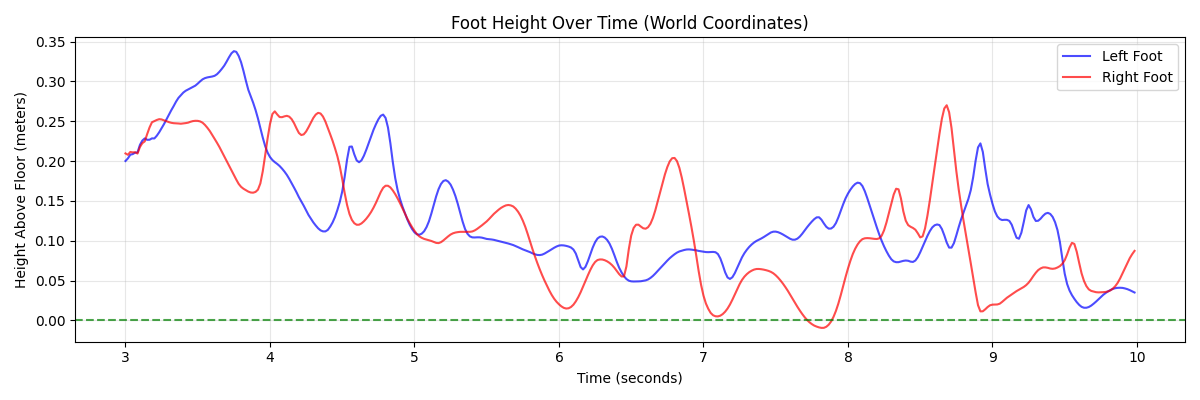


Left foot height range: 0.016 to 0.338 m
Right foot height range: -0.010 to 0.270 m


In [7]:
# Track and plot foot z-positions over time
import matplotlib.pyplot as plt

# BODY_34 keypoint indices for feet
LEFT_FOOT_IDX = 21
RIGHT_FOOT_IDX = 25

def create_floor_transform(floor_plane_eq):
    """Create rotation and translation to transform camera coords to world coords.
    
    World frame: z-up (floor normal), y-forward (camera direction projected on floor).
    
    Args:
        floor_plane_eq: [a, b, c, d] where ax + by + cz + d = 0
        
    Returns:
        R: 3x3 rotation matrix
        t: 3-element translation vector
    """
    a, b, c, d = floor_plane_eq
    n = np.array([a, b, c])
    n = n / np.linalg.norm(n)  # floor normal in camera coords
    
    # z_world is the floor normal
    z_world = n
    
    # Camera forward in ZED RIGHT_HANDED_Z_UP is (0, 1, 0)
    cam_forward = np.array([0, 1, 0])
    
    # y_world: camera forward projected onto floor plane, normalized
    y_world = cam_forward - np.dot(cam_forward, z_world) * z_world
    y_norm = np.linalg.norm(y_world)
    
    if y_norm < 1e-6:
        # Camera looking straight up/down, use camera right as fallback
        cam_right = np.array([1, 0, 0])
        x_world = cam_right - np.dot(cam_right, z_world) * z_world
        x_world = x_world / np.linalg.norm(x_world)
        y_world = np.cross(z_world, x_world)
    else:
        y_world = y_world / y_norm
        x_world = np.cross(y_world, z_world)
    
    # Rotation matrix: rows are world basis vectors in camera coords
    # p_world = R @ p_camera
    R = np.vstack([x_world, y_world, z_world])
    
    # After rotation, floor points have z = n · p = -d
    # Translate by +d to shift floor to z=0
    t = np.array([0, 0, d])
    
    return R, t


def transform_keypoints(keypoints, R, t):
    """Transform keypoints from camera to world coordinates."""
    return (R @ keypoints.T).T + t


# Create floor transform
if floor_plane_eq is not None:
    R, t = create_floor_transform(floor_plane_eq)
    print("Floor transform created:")
    print(f"  Rotation matrix:\n{R}")
    print(f"  Translation: {t}")
else:
    R, t = np.eye(3), np.zeros(3)
    print("No floor plane detected, using identity transform")

# Extract foot z-positions (height above floor) for each frame
frame_indices = []
left_foot_z = []
right_foot_z = []

for frame_idx, frame_bodies in enumerate(frames_data):
    if frame_bodies:
        first_person_id = list(frame_bodies.keys())[0]
        keypoints_cam = frame_bodies[first_person_id]['keypoints_3d']
        
        # Transform to world coordinates
        keypoints_world = transform_keypoints(keypoints_cam, R, t)
        
        frame_indices.append(frame_idx)
        left_foot_z.append(keypoints_world[LEFT_FOOT_IDX, 2])
        right_foot_z.append(keypoints_world[RIGHT_FOOT_IDX, 2])

# Convert to numpy arrays
frame_indices = np.array(frame_indices)
left_foot_z = np.array(left_foot_z)
right_foot_z = np.array(right_foot_z)

# Convert frame indices to time (seconds)
time_seconds = frame_indices / fps

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time_seconds, left_foot_z, label='Left Foot', color='blue', alpha=0.7)
ax.plot(time_seconds, right_foot_z, label='Right Foot', color='red', alpha=0.7)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Height Above Floor (meters)')
ax.set_title('Foot Height Over Time (World Coordinates)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Floor')

plt.tight_layout()
plt.show()

print(f"\nLeft foot height range: {left_foot_z.min():.3f} to {left_foot_z.max():.3f} m")
print(f"Right foot height range: {right_foot_z.min():.3f} to {right_foot_z.max():.3f} m")

In [8]:
# Close ZED camera
zed.close()
print("ZED camera closed")

ZED camera closed


In [9]:
# Define bone connections based on body format
if BODY_FORMAT == sl.BODY_FORMAT.BODY_34:
    # BODY_34 skeleton connections
    bones = [
        (0, 1), (1, 2), (2, 3), (3, 26),  # Spine to head
        (2, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (7, 10),  # Left arm
        (2, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (14, 17),  # Right arm
        (0, 18), (18, 19), (19, 20), (20, 21), (20, 32),  # Left leg
        (0, 22), (22, 23), (23, 24), (24, 25), (24, 33),  # Right leg
        (26, 27), (26, 28), (26, 30), (28, 29), (30, 31),  # Face
    ]
else:
    # BODY_18 skeleton connections
    # 0:NOSE, 1:NECK, 2:R_SHOULDER, 3:R_ELBOW, 4:R_WRIST,
    # 5:L_SHOULDER, 6:L_ELBOW, 7:L_WRIST, 8:R_HIP, 9:R_KNEE,
    # 10:R_ANKLE, 11:L_HIP, 12:L_KNEE, 13:L_ANKLE,
    # 14:R_EYE, 15:L_EYE, 16:R_EAR, 17:L_EAR
    bones = [
        # Head
        (0, 1),    # Nose - Neck
        (0, 14), (0, 15),  # Nose - Eyes
        (14, 16), (15, 17),  # Eyes - Ears
        # Torso
        (1, 2), (1, 5),  # Neck - Shoulders
        (2, 8), (5, 11),  # Shoulders - Hips
        (8, 11),  # Hip - Hip
        # Right arm
        (2, 3), (3, 4),  # R_Shoulder - R_Elbow - R_Wrist
        # Left arm
        (5, 6), (6, 7),  # L_Shoulder - L_Elbow - L_Wrist
        # Right leg
        (8, 9), (9, 10),  # R_Hip - R_Knee - R_Ankle
        # Left leg
        (11, 12), (12, 13),  # L_Hip - L_Knee - L_Ankle
    ]

print(f"Bone connections: {len(bones)}")

Bone connections: 33


In [10]:
# 2D Video visualization with skeleton overlay using ipycanvas
from ipycanvas import Canvas, hold_canvas

# Create canvas at half resolution for performance
scale = 0.5
canvas_width = int(img_width * scale)
canvas_height = int(img_height * scale)

canvas = Canvas(width=canvas_width, height=canvas_height)

# Colors for different persons
person_colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']

def draw_frame_2d(n):
    frame_bodies = frames_data[n]
    
    with hold_canvas(canvas):
        # Load and draw the frame image
        img = Image.open(f"tmp/{n:06d}.png")
        img = img.resize((canvas_width, canvas_height), Image.LANCZOS)
        canvas.put_image_data(np.array(img), 0, 0)
        
        # Draw skeletons for all persons
        for person_idx, (person_id, data) in enumerate(frame_bodies.items()):
            keypoints_2d = data['keypoints_2d'] * scale
            bbox = data['bounding_box_2d'] * scale
            color = person_colors[person_idx % len(person_colors)]
            
            # Draw bounding box (for debugging alignment)
            if len(bbox) >= 4:
                canvas.stroke_style = '#ffffff'
                canvas.line_width = 1
                canvas.stroke_rect(bbox[0][0], bbox[0][1], 
                                   bbox[1][0] - bbox[0][0], 
                                   bbox[2][1] - bbox[0][1])
            
            # Draw bones
            canvas.stroke_style = color
            canvas.line_width = 2
            for start_idx, end_idx in bones:
                if start_idx < len(keypoints_2d) and end_idx < len(keypoints_2d):
                    x1, y1 = keypoints_2d[start_idx]
                    x2, y2 = keypoints_2d[end_idx]
                    # Skip if any coordinate is invalid (nan or 0,0)
                    if x1 > 0 and y1 > 0 and x2 > 0 and y2 > 0:
                        canvas.begin_path()
                        canvas.move_to(x1, y1)
                        canvas.line_to(x2, y2)
                        canvas.stroke()
            
            # Draw joints
            canvas.fill_style = color
            for x, y in keypoints_2d:
                if x > 0 and y > 0:
                    canvas.fill_arc(x, y, 3, 0, 2 * np.pi)
            
            # Label person ID
            canvas.fill_style = color
            canvas.font = '12px sans-serif'
            if len(bbox) >= 1:
                canvas.fill_text(f"ID:{person_id}", bbox[0][0], bbox[0][1] - 5)

# Display canvas with slider
slider_2d = widgets.IntSlider(
    min=0,
    max=len(frames_data)-1,
    step=1,
    value=0,
    description='Frame:',
    layout=widgets.Layout(width='100%')
)

frame_label = widgets.Label(value=f"Frame 0 / {len(frames_data)-1}")

def on_slider_change(change):
    frame_label.value = f"Frame {change['new']} / {len(frames_data)-1}"
    draw_frame_2d(change['new'])

slider_2d.observe(on_slider_change, names='value')

# Initial draw
draw_frame_2d(0)

display(VBox([canvas, HBox([slider_2d, frame_label])]))

In [11]:
# Create k3d plot
plot = k3d.plot(grid=(-3, -3, -1, 3, 3, 3), camera_mode='orbit')

# Create floor plane from equation, sized to keypoints bounding box
if floor_plane_eq is not None:
    a, b, c, d = floor_plane_eq
    
    # Use X/Y extent from keypoints bbox, with some padding
    padding = 0.5
    x_min, x_max = keypoints_min[0] - padding, keypoints_max[0] + padding
    y_min, y_max = keypoints_min[1] - padding, keypoints_max[1] + padding
    
    # Calculate Z for each corner using plane equation: z = (-ax - by - d) / c
    def plane_z(x, y):
        if abs(c) > 1e-6:
            return (-a * x - b * y - d) / c
        return 0
    
    floor_verts = np.array([
        [x_min, y_min, plane_z(x_min, y_min)],
        [x_max, y_min, plane_z(x_max, y_min)],
        [x_max, y_max, plane_z(x_max, y_max)],
        [x_min, y_max, plane_z(x_min, y_max)],
    ], dtype=np.float32)
    
    floor_indices = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.uint32)
    
    floor_plane_mesh = k3d.mesh(
        floor_verts,
        floor_indices,
        color=0x00ff00,
        opacity=0.3,
        name="Floor Plane (from equation)"
    )
    plot += floor_plane_mesh
    
    print(f"Floor plane added from equation: {a:.3f}x + {b:.3f}y + {c:.3f}z + {d:.3f} = 0")
    print(f"  Plane corners Z: {[f'{plane_z(x,y):.2f}' for x,y in [(x_min,y_min), (x_max,y_min), (x_max,y_max), (x_min,y_max)]]}")
else:
    # Add a reference floor grid at z=0
    padding = 0.5
    x_min, x_max = keypoints_min[0] - padding, keypoints_max[0] + padding
    y_min, y_max = keypoints_min[1] - padding, keypoints_max[1] + padding
    
    grid_verts = np.array([
        [x_min, y_min, 0],
        [x_max, y_min, 0],
        [x_max, y_max, 0],
        [x_min, y_max, 0],
    ], dtype=np.float32)
    grid_indices = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.uint32)
    floor_ref = k3d.mesh(grid_verts, grid_indices, color=0x444444, opacity=0.2, name="Z=0 Reference")
    plot += floor_ref
    print("Z=0 reference plane added (no floor detected)")

# Add skeleton visualization placeholders
joints_plot = k3d.points([], point_size=0.05, shader='flat', color=0xff0000, name="Joints")
bones_plot = k3d.lines([], bones, width=0.01, color=0xff0000, indices_type="segment", name="Bones")

plot += joints_plot
plot += bones_plot

# Frame update function
def set_frame(n):
    frame_bodies = frames_data[n]
    
    if frame_bodies:
        # Show first person only for 3D view
        first_person_id = list(frame_bodies.keys())[0]
        keypoints = frame_bodies[first_person_id]['keypoints_3d']
        
        joints_plot.positions = keypoints
        bones_plot.vertices = keypoints
    else:
        joints_plot.positions = np.array([], dtype=np.float32).reshape(0, 3)
        bones_plot.vertices = np.array([], dtype=np.float32).reshape(0, 3)

plot.display()

interact(
    set_frame,
    n=widgets.IntSlider(
        min=0,
        max=len(frames_data)-1,
        step=1,
        value=0,
        description='Frame:',
        layout=widgets.Layout(width='100%')
    )
)

Floor plane added from equation: 0.005x + 0.038y + 0.999z + 1.008 = 0
  Plane corners Z: ['-1.00', '-1.02', '-1.16', '-1.15']


Output()

interactive(children=(IntSlider(value=0, description='Frame:', layout=Layout(width='100%'), max=599), Output()…

<function __main__.set_frame(n)>

In [12]:
1# Debug: Show keypoint Z values for first frame with data
for i, frame_bodies in enumerate(frames_data):
    if frame_bodies:
        first_person_id = list(frame_bodies.keys())[0]
        keypoints = frame_bodies[first_person_id]['keypoints_3d']
        
        z_values = keypoints[:, 2]
        print(f"Frame {i}, Person {first_person_id}:")
        print(f"  Z min: {z_values.min():.3f} m")
        print(f"  Z max: {z_values.max():.3f} m")
        print(f"  Z mean: {z_values.mean():.3f} m")
        print(f"  Pelvis (joint 0) position: {keypoints[0]}")
        
        if floor_plane_eq is not None:
            # Distance from pelvis to floor plane
            pelvis = keypoints[0]
            dist = abs(floor_plane_eq[0]*pelvis[0] + floor_plane_eq[1]*pelvis[1] + floor_plane_eq[2]*pelvis[2] + floor_plane_eq[3])
            print(f"  Pelvis distance to floor: {dist:.3f} m")
        break

Frame 180, Person 0:
  Z min: -0.836 m
  Z max: 0.587 m
  Z mean: -0.021 m
  Pelvis (joint 0) position: [-0.33857504  0.60246634 -0.04682651]
  Pelvis distance to floor: 0.983 m
